# Práctica 8 - Componentes principales

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.preprocessing import MinMaxScaler    # Herramientas de polinomios

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from formulaic import model_matrix
from formulaic import Formula

# Paquetes para clustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Para componentes principales
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Ejercicio 1

Dada la tabla de datos de longitud y acho

In [2]:
datos = {
    'longitud':[93,94,96,101,102,103,104,106],
    'ancho':[76,78,80,84,85,82,83,83]
}

In [3]:
X = pd.DataFrame(datos)
X

longitud  ancho
0        93     76
1        94     78
2        96     80
3       101     84
4       102     85
5       103     82
6       104     83
7       106     83

### Inciso a

Normalizar las variables para que tengan media 0 y hacer el scatter plot. Estimar la presencia de correlación a partir de este gráfico

In [4]:
X_star = X-X.mean()

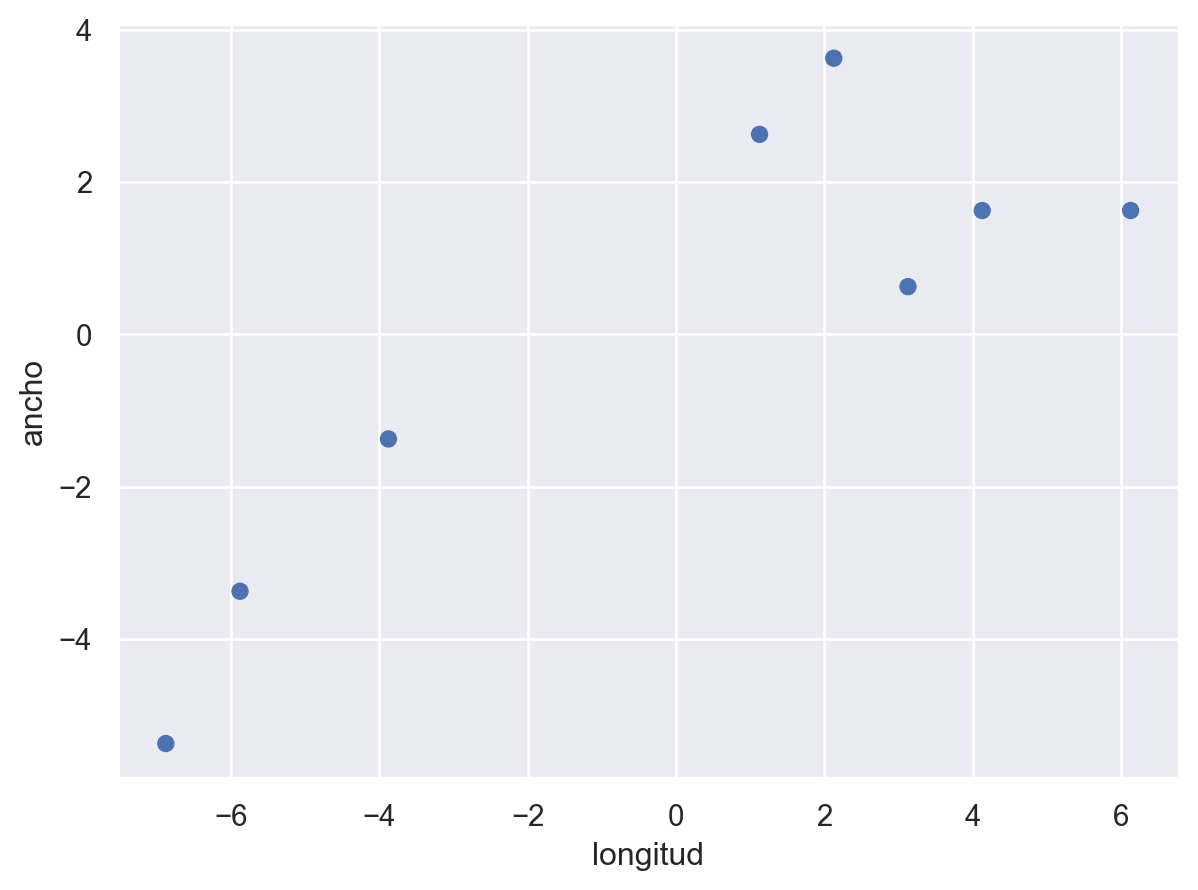

In [5]:
(
    so.Plot(data=X_star)
    .add(so.Dot(),x="longitud",y="ancho")
)

Podemos ver que parece haber una correlación positiva entre las variables

### Inciso b
Calcular la matriz de covarianzas y hallar sus autovalores y autovectores

In [6]:
Sigma = (X_star.T @ X_star) / len(X_star)
Sigma

longitud      ancho
longitud  20.859375  11.421875
ancho     11.421875   8.484375

In [7]:
gamma, U = np.linalg.eigh(Sigma)
gamma = np.flip(gamma)
U = np.flip(U)
print("Los autovalores de Sigma son:", gamma)
print("Los autovectores de Sigma son:", U)

Los autovalores de Sigma son: [27.66203992  1.68171008]
Los autovectores de Sigma son: [[-0.51170211 -0.85916293]
 [-0.85916293  0.51170211]]


### Inciso c

Hallar las componentes principales

In [8]:
Z = X_star @ U
Z

0         1
0  8.135953  3.156346
1  5.905925  3.320588
2  3.164195  2.625666
3 -2.830968  0.376660
4 -4.201833  0.029199
5 -2.136046 -2.365070
6 -3.506911 -2.712531
7 -4.530315 -4.430857

### Inciso d

Decidir si la información está mayormente representada en alguna de estas dos componentes.

La información parece estar mucho más representada por la variable $z_1$, aparte sabemos que el autovalor asociado al autovector $u_1$ es 27, lo cual nos indica que es la dirección que más representa la información. 

### Inciso e

Indicar la proporción de variabilidad explicada por cada una de ellas. ¿A qué conclusión puede llegar?

In [9]:
print("Variabilidad explicada por z1:", gamma[0] / sum(gamma))
print("Variabilidad explicada por z2:", gamma[1] / sum(gamma))

Variabilidad explicada por z1: 0.9426893265004208
Variabilidad explicada por z2: 0.05731067349957914


Podemos concluir que casi toda la variabilidad del dataset está explicada con una dirección, lo cual es esperable ya que longitud y ancho son dos variables que están altamente correlacionadas.

## Ejercicio 2 

Sea $A=\begin{equation}
\begin{pmatrix}
3 & 1 & 1\\
1 & 3 & 1\\
1 & 1 & 5
\end{pmatrix}
\end{equation}$ la matriz de covarianza de una cierta muestra de datos cuya media es 0.


### Inciso a

Hallar los autovalores y autovectores de la matriz de covarianza

In [10]:
A = pd.DataFrame({"x1":[3,1,1],"x2":[1,3,1],"x3":[1,1,5]})
A

x1  x2  x3
0   3   1   1
1   1   3   1
2   1   1   5

In [11]:
gamma, U = np.linalg.eigh(A)
gamma = gamma[::-1]
U = U[::-1]
print("Los autovalores son:",gamma)
print("Los autovectores son:", U)

Los autovalores son: [6. 3. 2.]
Los autovectores son: [[ 0.         -0.57735027  0.81649658]
 [-0.70710678  0.57735027  0.40824829]
 [ 0.70710678  0.57735027  0.40824829]]


## Inciso b

Dar la expresion de los componentes principales $z_1$,$z_2$,$z_3$ y calcular la proporción de variabilidad explicada por cada una de ellos

$Z = X^{\star} U$

$z_1 = X^{\star} u_1$

$z_2 = X^{\star} u_2$ 

$z_3 = X^{\star} u_3$

In [12]:
print("Variabilidad explicada por z1:", gamma[0] / sum(gamma))
print("Variabilidad explicada por z2:", gamma[1] / sum(gamma))
print("Variabilidad explicada por z3:", gamma[2] / sum(gamma))

Variabilidad explicada por z1: 0.5454545454545454
Variabilidad explicada por z2: 0.2727272727272727
Variabilidad explicada por z3: 0.18181818181818177


### Inciso c

Hallar los _scores_ de las primeras dos componentes principales correspondientes a la observación $(x_1,x_2,x_3)=(2,2,1)$ (es decir, los valores de $z_1$ y $z_2$ para dicha observación)

In [13]:
x_obs = np.array([2,2,1])
z_1_obs = x_obs @ U[0]
z_2_obs = x_obs @ U[1]
z_1_obs,z_2_obs

(-0.338203957451525, 0.14873526647001822)

## Ejercicio 3

Implementar un programa que reciba como input un archivo de datos y un número _p_acum_ y devuelva la mínima cantidad de componentes principales que deben considerarse para que el procentaje de varianza sea _p_acum_

In [14]:
def cant_de_componentes(df,p_acum):
    X_star = df-df.mean()
    Sigma = (X_star.T @ X_star)/len(X_star)
    gamma, U = np.linalg.eigh(Sigma)
    gamma, U = np.flip(gamma),np.flip(U)
    suma_autovalores = sum(gamma)
    varianza_explicada = 0
    res = 0
    for autovalor in gamma:
        res +=1
        varianza_explicada += autovalor/suma_autovalores
        if varianza_explicada >= p_acum:
            return res
    return res

In [15]:
# Para testear, con la X del ejercicio anterior
#cant_de_componentes(X,0.7)
#cant_de_componentes(X,0.95)

## Ejercicio 4

Considerando el archivo de datos $\texttt{p8-chalets.csv}$ se pide:

In [16]:
chalets = pd.read_csv("../../datos/p8-chalets.csv")
chalets.head()

Promotora  DuracionHipoteca  PrecioMedio  SuperficieCocina
0          1               8.7          0.3               3.1
1          2              14.3          0.9               7.4
2          3              18.9          1.8               9.0
3          4              19.0          0.8               9.4
4          5              20.5          0.9               8.3

### Inciso a

Graficar los diagramas de dispersión de las variables de a pares. Estimar la presencia de correlación entre las variables a partir de estos gráficos.

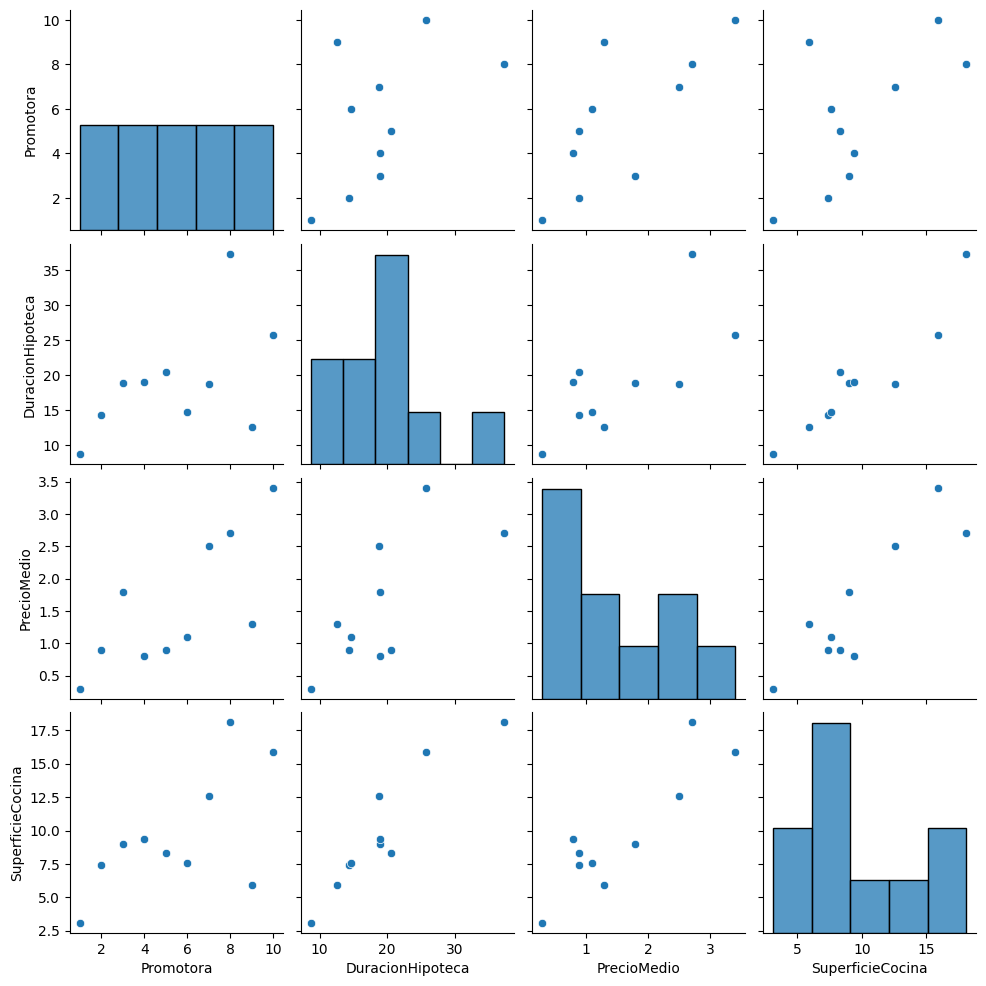

In [17]:
sns.pairplot(data=chalets)

Pareciera que hay bastante correlación entre algunas de las variables

In [18]:
# Llevo chalets a media 0
chalets_star = chalets - chalets.mean()

# Defino Sigma de chalets
Sigma_chalets = (chalets_star.T @ chalets_star)/len(chalets_star)

# La muestro
Sigma_chalets

Promotora  DuracionHipoteca  PrecioMedio  SuperficieCocina
Promotora             8.250           11.3350       2.0250            7.9550
DuracionHipoteca     11.335           56.9685       5.1705           30.4775
PrecioMedio           2.025            5.1705       0.8941            3.6479
SuperficieCocina      7.955           30.4775       3.6479           18.7641

### Inciso c

A partir de lo observado, ¿resulta razonable pensar en un análisis de componentes principales para reducir la dimensión del problema?

Si, parece razonable porque uno puede observar que hay variables que están altamente correlacionadas

### Inciso d

Hallar la primera componente principal

Sabemos que $z_1 = X^{\star} u_1$

In [19]:
gamma_chalets, U_chalets = np.linalg.eigh(Sigma_chalets)
gamma_chalets, U_chalets = gamma_chalets[::-1],U_chalets[::-1]

In [20]:
z1_chalets = chalets_star @ U_chalets[0]
z1_chalets

0    10.342926
1     3.990958
2    -0.333370
3    -0.100624
4    -0.494765
5     4.743489
6    -0.902793
7   -18.072284
8     8.101159
9    -7.274696
dtype: float64

### Inciso e

Indicar qué porcentaje de variabilidad total logra explicar este componente

In [21]:
var_explicada_chalets = gamma_chalets[0] / sum(gamma_chalets)
var_explicada_chalets

0.9092699928310696

## Ejercicio 5

Considerar el dataset $\texttt{p8-iris.txt}$, que representa información del largo y ancho del pétalo y del sépalo de diversas muestras de la especie Iris, la cual se puede distinguir en varias subespecies. Aplicar el programa del ejercicio anterior para determinar la menor cantidad de componentes principales necesarias para alcanzar un 90% de variabilidad. Graficar los datos transformados que se obtienen luego de reducir las variables.

In [22]:
iris = pd.read_csv("../../datos/p8-iris.txt",sep="\t")
iris

LongSepalo  AnchoSepalo  LongPetalo  AnchoPetalo
0           5.1          3.5         1.4          0.2
1           4.9          3.0         1.4          0.2
2           4.7          3.2         1.3          0.2
3           4.6          3.1         1.5          0.2
4           5.0          3.6         1.4          0.2
..          ...          ...         ...          ...
145         6.7          3.0         5.2          2.3
146         6.3          2.5         5.0          1.9
147         6.5          3.0         5.2          2.0
148         6.2          3.4         5.4          2.3
149         5.9          3.0         5.1          1.8

[150 rows x 4 columns]

In [23]:
cant_de_componentes(iris,0.9)

1

Necesitamos solo 1 variable para explicar todo, esto quiere decir que todas están muy altamente correlacionadas, lo cual tiene sentido si nos fijamos cuáles son las variables.

In [25]:
X_star_iris = iris-iris.mean()
Sigma_iris = (X_star_iris.T @ X_star_iris)/len(X_star_iris)
gamma_iris, U_iris = np.linalg.eigh(Sigma_iris)
gamma_iris, U_iris = np.flip(gamma_iris),np.flip(U_iris)

In [26]:
z1_iris = X_star_iris @ U_iris[0]
z1_iris

0      0.778354
1      0.887476
2      0.999210
3      0.932753
4      0.806768
         ...   
145   -0.267521
146   -0.277266
147   -0.421089
148   -0.227794
149   -0.301100
Length: 150, dtype: float64

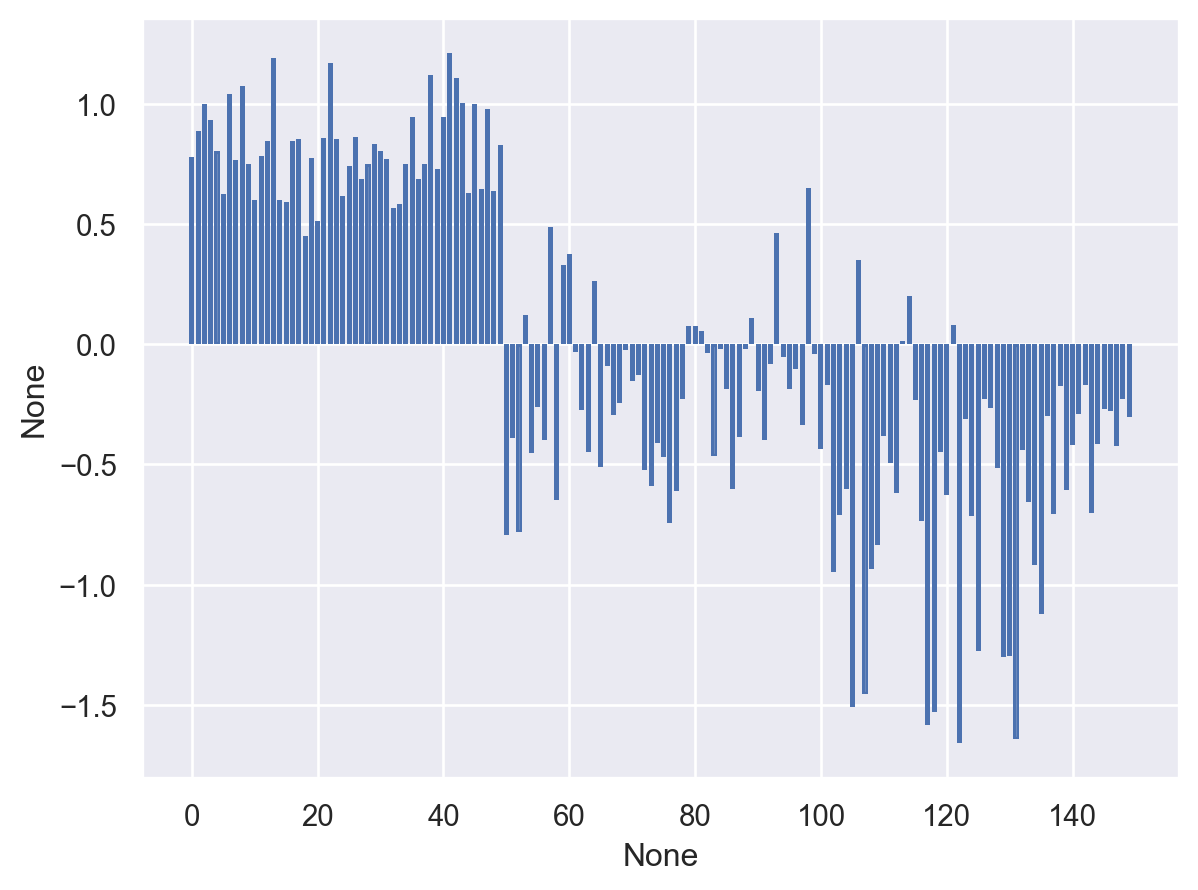

In [33]:
(
    so.Plot(data=iris,x=iris.index,y=z1_iris)
    .add(so.Bar())
)

## Ejercicio 6

Con el objetos de obtener índices útiles para la gestión hospitalaria basados en técnicas estadísticas multivariantes descriptivas se recogió información del Hospital de Algeciras correspondiente a los ingresos hospitalarios del período 2007-2008. Se estudiaron las siguientes variables habitualmente monitorizadas por el Servicio Andaluz de Salud del Sistema Nacional de Salud Español:

- NI: Número de ingresos
- MO: Tasa de mortalidad
- RE: Tasa de egresos
- NE: Número de consultas externas
- ICM: Índice cardíaco máximo
- ES: Número de estancias

Las variables se midieron en un total de 22486 ingresos. En el archivo $\texttt{p8-hospitales.csv}$ se aprecia la distribución de los valores obtenidos en las variables listadas por los servicios del hospital de Algeciras. Como hay variables con distintos órdenes de magnitud, en el archivo $\texttt{p8-hospitales-escalado.csv}$ se escalaron las variables a un mismo rango. Utilizando el archivo escalado: 

In [37]:
hospitales = pd.read_csv("../../datos/p8-hospitales-escalado.csv")
hospitales

Servicio        NI     MO        RE        NE       ICM  \
0                Cirugia  0.358385  0.304  0.244275  0.257901  0.564103   
1        Tocoginecologia  1.000000  0.024  0.221374  0.065260  0.008547   
2            Hematologia  0.000000  0.328  0.503817  0.356053  1.000000   
3            Cardiologia  0.040369  0.176  0.282443  0.000000  0.675214   
4              Digestivo  0.044879  0.472  0.229008  0.294376  0.470085   
5       Medicina.Interna  0.790638  1.000  0.404580  0.781110  0.452991   
6             Neumologia  0.015675  0.408  0.320611  0.020049  0.820513   
7   Otorrinolaringologia  0.034572  0.168  0.160305  0.799670  0.307692   
8           Oftalmologia  0.107580  0.000  0.000000  0.788719  0.264957   
9              Pediatria  0.700666  0.024  0.145038  0.246065  0.000000   
10           Psiquiatria  0.028559  0.000  1.000000  1.000000  0.735043   
11         Traumatologia  0.197767  0.056  0.099237  0.448045  0.555556   
12              Urologia  0.144299  0.160  0.282443  0.104916  0.239316   

          ES  
0   0.443958  
1   0.447995  
2   0.082968  
3   0.160020  
4   0.130156  
5   1.000000  
6   0.085489  
7   0.044112  
8   0.000000  
9   0.236174  
10  0.121334  
11  0.295901  
12  0.167966

### Inciso a

Calcular las dos primeras componentes principales

Para hallar $z_1$ y $z_2$ debemos mutliplicar $X^{\star}$ a $u_1$ y $u_2$ respectivamente, donde $u_1$ y $u_2$ son los autovectores asociados a los dos autovalores más grandes de la matriz de covarianza $\Sigma$

In [40]:
# Ponemos a "servicio" como nuevo índice
hospitales = hospitales.set_index("Servicio")

In [44]:
# Llevamos hospitales a media 0
hospitales_star = hospitales-hospitales.mean()

# Calculamos la matriz de covarianza
Sigma_hospitales = (hospitales_star.T @ hospitales_star) / len(hospitales_star)

# Obtenemos sus autovalores y autovectores, y los ponemos en orden decreciente
gamma_hospitales, U_hospitales = np.linalg.eigh(Sigma_hospitales)
gamma_hospitales, U_hospitales = gamma_hospitales[::-1],U_hospitales[::-1]

# Calculamos las dos primeras componentes principales
z1_hospitales = hospitales_star @ U_hospitales[0]
z2_hospitales = hospitales_star @ U_hospitales[1]

In [43]:
z1_hospitales,z2_hospitales

(Servicio
 Cirugia                -0.020105
 Tocoginecologia        -0.136212
 Hematologia            -0.123856
 Cardiologia             0.122867
 Digestivo               0.063075
 Medicina.Interna       -0.340311
 Neumologia             -0.022818
 Otorrinolaringologia    0.109405
 Oftalmologia            0.107970
 Pediatria              -0.031835
 Psiquiatria            -0.033159
 Traumatologia           0.080250
 Urologia                0.224728
 dtype: float64,
 Servicio
 Cirugia                -0.074789
 Tocoginecologia         0.523606
 Hematologia            -0.222216
 Cardiologia             0.133394
 Digestivo              -0.091734
 Medicina.Interna       -0.885686
 Neumologia             -0.042863
 Otorrinolaringologia   -0.017484
 Oftalmologia            0.168900
 Pediatria               0.486168
 Psiquiatria            -0.289760
 Traumatologia           0.053830
 Urologia                0.258633
 dtype: float64)

### Inciso b

¿Qué porcentaje de variabilidad logra captar cada una de ellas?

In [45]:
print("Porcentaje de variabilidad capturado por z1:",gamma_hospitales[0]/sum(gamma_hospitales))
print("Porcentaje de variabilidad capturado por z2:",gamma_hospitales[1]/sum(gamma_hospitales))

Porcentaje de variabilidad capturado por z1: 0.39859471690680204
Porcentaje de variabilidad capturado por z2: 0.27335451524861154


### Inciso c

¿Considera adecuado considerar dos componentes principales?

No, solo estamos consiguiendo cubrir alrededor del 67% de la variabilidad de los datos, lo cual no parece decirnos demasiado del dataset, tenemos que usar algunas variables más.

### Inciso d

Hallar la correlación entre las nuevas variables y las originales (por medio de $R^2$)

In [57]:
df = pd.concat([z1_hospitales,z2_hospitales],axis=1).rename(columns={0:"z1",1:"z2"})
df

z1        z2
Servicio                                
Cirugia              -0.020105 -0.074789
Tocoginecologia      -0.136212  0.523606
Hematologia          -0.123856 -0.222216
Cardiologia           0.122867  0.133394
Digestivo             0.063075 -0.091734
Medicina.Interna     -0.340311 -0.885686
Neumologia           -0.022818 -0.042863
Otorrinolaringologia  0.109405 -0.017484
Oftalmologia          0.107970  0.168900
Pediatria            -0.031835  0.486168
Psiquiatria          -0.033159 -0.289760
Traumatologia         0.080250  0.053830
Urologia              0.224728  0.258633

### Inciso e

¿Se obtienen las mismas conclusiones si se usa el archivo sin escalar?

In [61]:
hospitales_sin_escalar = pd.read_csv("../../datos/p8-hospitales.csv")
hospitales_sin_escalar

Servicio    NI    MO    RE     NE   ICM     ES
0                Cirugia  2158   3.8   3.4   8567  1.17  21879
1        Tocoginecologia  5146   0.3   3.1   3782  0.52  22068
2            Hematologia   489   4.1   6.8  11005  1.68   4980
3            Cardiologia   677   2.2   3.9   2161  1.30   8587
4              Digestivo   698   5.9   3.2   9473  1.06   7189
5       Medicina.Interna  4171  12.5   5.5  21563  1.04  47909
6             Neumologia   562   5.1   4.4   2659  1.47   5098
7   Otorrinolaringologia   650   2.1   2.3  22024  0.87   3161
8           Oftalmologia   990   0.0   0.2  21752  0.82   1096
9              Pediatria  3752   0.3   2.1   8273  0.51  12152
10           Psiquiatria   622   0.0  13.3  27000  1.37   6776
11         Traumatologia  1410   0.7   1.5  13290  1.16  14948
12              Urologia  1161   2.0   3.9   4767  0.79   8959

In [62]:
# Ponemos a "servicio" como nuevo índice
hospitales_sin_escalar = hospitales_sin_escalar.set_index("Servicio")

In [63]:
# Llevamos hospitales a media 0
hospitales_se_star = hospitales_sin_escalar-hospitales_sin_escalar.mean()

# Calculamos la matriz de covarianza
Sigma_hospitales_se = (hospitales_se_star.T @ hospitales_se_star) / len(hospitales_se_star)

# Obtenemos sus autovalores y autovectores, y los ponemos en orden decreciente
gamma_hospitales_se, U_hospitales_se = np.linalg.eigh(Sigma_hospitales_se)
gamma_hospitales_se, U_hospitales_se = gamma_hospitales_se[::-1],U_hospitales_se[::-1]

# Calculamos las dos primeras componentes principales
z1_hospitales_se = hospitales_se_star @ U_hospitales_se[0]
z2_hospitales_se = hospitales_se_star @ U_hospitales_se[1]

In [64]:
z1_hospitales_se,z2_hospitales_se

(Servicio
 Cirugia                 -9458.657333
 Tocoginecologia        -10109.135031
 Hematologia              7533.243966
 Cardiologia              3100.874355
 Digestivo                5194.722266
 Medicina.Interna       -34010.602668
 Neumologia               6608.527161
 Otorrinolaringologia    10403.344351
 Oftalmologia            12424.543042
 Pediatria                 157.600452
 Psiquiatria              7300.479946
 Traumatologia           -2129.211949
 Urologia                 2984.271445
 dtype: float64,
 Servicio
 Cirugia                  427.035762
 Tocoginecologia         3410.605260
 Hematologia            -1239.801462
 Cardiologia            -1054.225552
 Digestivo              -1031.231086
 Medicina.Interna        2441.551035
 Neumologia             -1168.966401
 Otorrinolaringologia   -1075.902978
 Oftalmologia            -736.284289
 Pediatria               2019.242779
 Psiquiatria            -1103.043586
 Traumatologia           -318.936263
 Urologia                

In [65]:
print("Porcentaje de variabilidad capturado por z1:",gamma_hospitales_se[0]/sum(gamma_hospitales_se))
print("Porcentaje de variabilidad capturado por z2:",gamma_hospitales_se[1]/sum(gamma_hospitales_se))

Porcentaje de variabilidad capturado por z1: 0.6874044276344053
Porcentaje de variabilidad capturado por z2: 0.30801609663221496


No, si no escalamos los datos, vemos que con dos variables podemos explicar el 98% de la varianza

## Ejercicio 7

Se realiza un estudio sobre la calidad del agua en 4 ríos distintos del país. En el estudio se miden las concentraciones de 4 sustancias presentes en el agua, realizandose una medición por día durante los 365 días de un año. Los datos recolectados (generados artificialmente en este ejercicio) se encuentran en el archivo $\texttt{p8-calidad-agua.csv}$. Cada columna representa una de las 4 variables medidas: $x_1$, $x_2$, $x_3$, $x_4$.

In [66]:
rios = pd.read_csv("../../datos/p8-calidad-agua.csv")
rios

x1       x2       x3       x4
0    0.01411  0.12445  1.04539  0.04318
1   -0.17200  1.01532  0.05276 -0.18680
2    1.03277 -0.00024  0.03330 -0.02765
3    0.06603  0.77159 -0.26459  0.05418
4    0.98548  0.06333 -0.03382 -0.09569
..       ...      ...      ...      ...
360 -0.09208  0.84087 -0.10243 -0.11231
361 -0.32223 -0.24897  1.13032  0.15636
362  1.15268 -0.17168  0.11728 -0.02610
363  0.94714  0.04118 -0.20791 -0.26628
364 -0.00756  0.89027  0.07742 -0.19212

[365 rows x 4 columns]

### Inciso a

Realizar un gráfico de dispersión de las variables $x_1$ y $x_2$. ¿Cuántos clusters puede observar?

In [78]:
rios = rios.rename(columns=lambda x : str.strip(x))
rios.columns

Index(['x1', 'x2', 'x3', 'x4'], dtype='object')

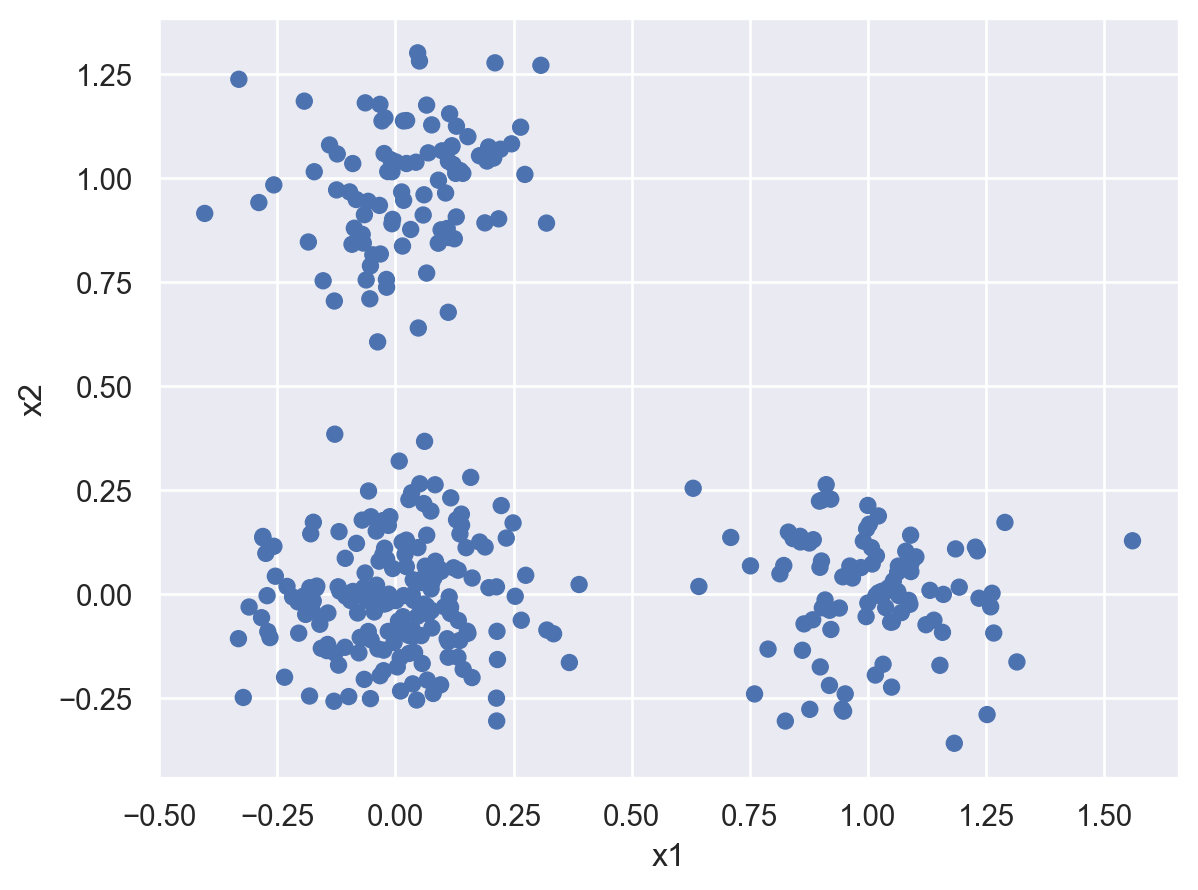

In [79]:
(
    so.Plot(data=rios,x="x1",y="x2")
    .add(so.Dot())
)

Parece haber 3 clusters

### Inciso b

Realizar un gráfico de dispersión de las variables $x_3$ y $x_4$. ¿Cuántos clusters puede observar?

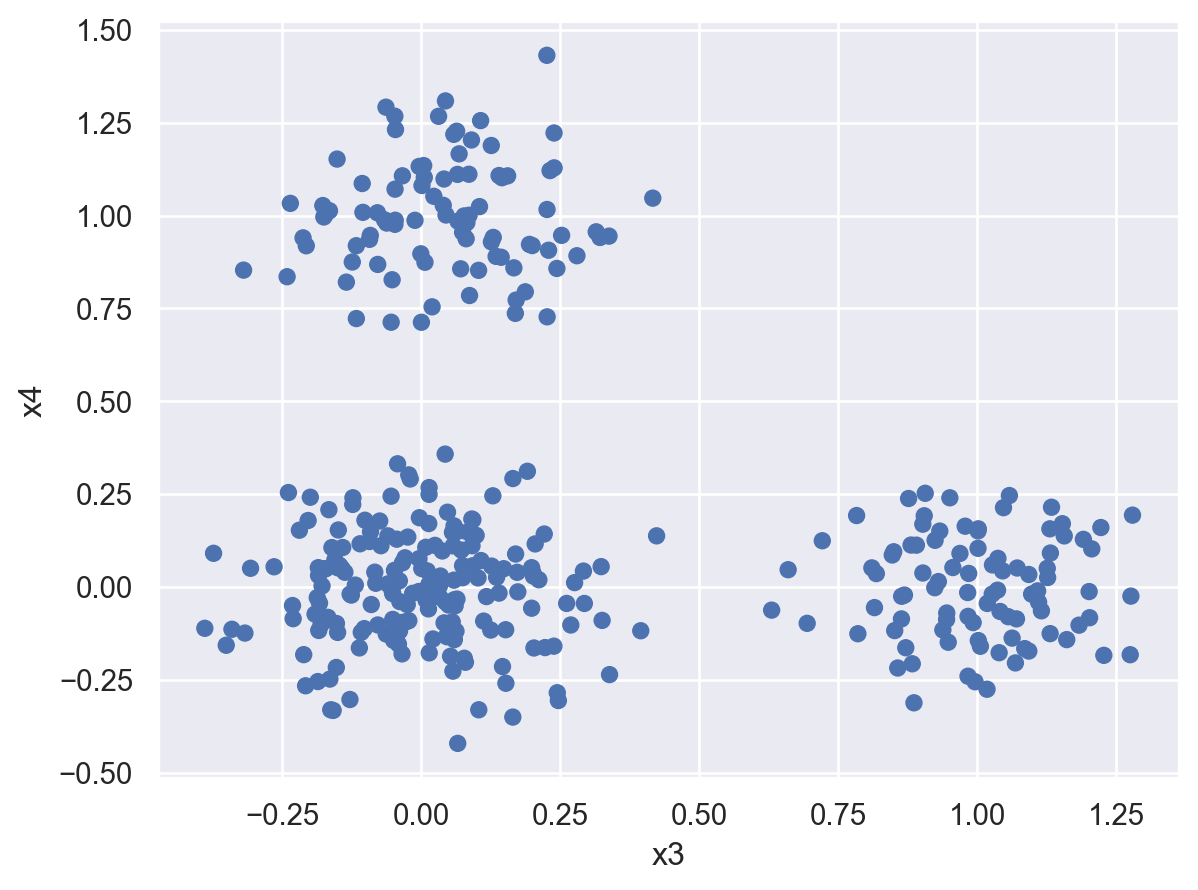

In [81]:
(
    so.Plot(data=rios,x="x3",y="x4")
    .add(so.Dot())
)

Acá también parece haber 3 clusters

### Inciso c

Realizar la descomposición en componentes principales de $z_1$ y $z_2$. ¿Cuántos clusters puede observar?

In [92]:
# Pongo rios en media 0
rios_star = rios - rios.mean()

# Calculo la matriz de covarianza
Sigma_rios = (rios_star.T @ rios_star) / len(rios_star)

# Saco sus autovalores y autovectores
gamma_rios, U_rios = np.linalg.eigh(Sigma_rios)
gamma_rios, U_rios = gamma_rios[::-1],U_rios[::-1]

# Defino z1 y z2
z1_rios = rios_star @ U_rios[0]
z2_rios = rios_star @ U_rios[1]

In [93]:
print("Porcentaje de variabilidad capturado por z1:",gamma_rios[0]/sum(gamma_rios))
print("Porcentaje de variabilidad capturado por z2:",gamma_rios[1]/sum(gamma_rios))

Porcentaje de variabilidad capturado por z1: 0.3444677000802354
Porcentaje de variabilidad capturado por z2: 0.3189901713330955


In [98]:
df_rios = pd.concat([z1_rios,z2_rios],axis=1).rename(columns={0:"z1",1:"z2"})
df_rios

z1        z2
0   -0.417405  0.590437
1    0.803352  0.027438
2   -0.212096 -0.196806
3    0.737033 -0.235076
4   -0.093888 -0.187062
..        ...       ...
360  0.781286 -0.028884
361 -0.502075  0.910126
362 -0.396898 -0.144847
363  0.096831 -0.116801
364  0.659884  0.016301

[365 rows x 2 columns]

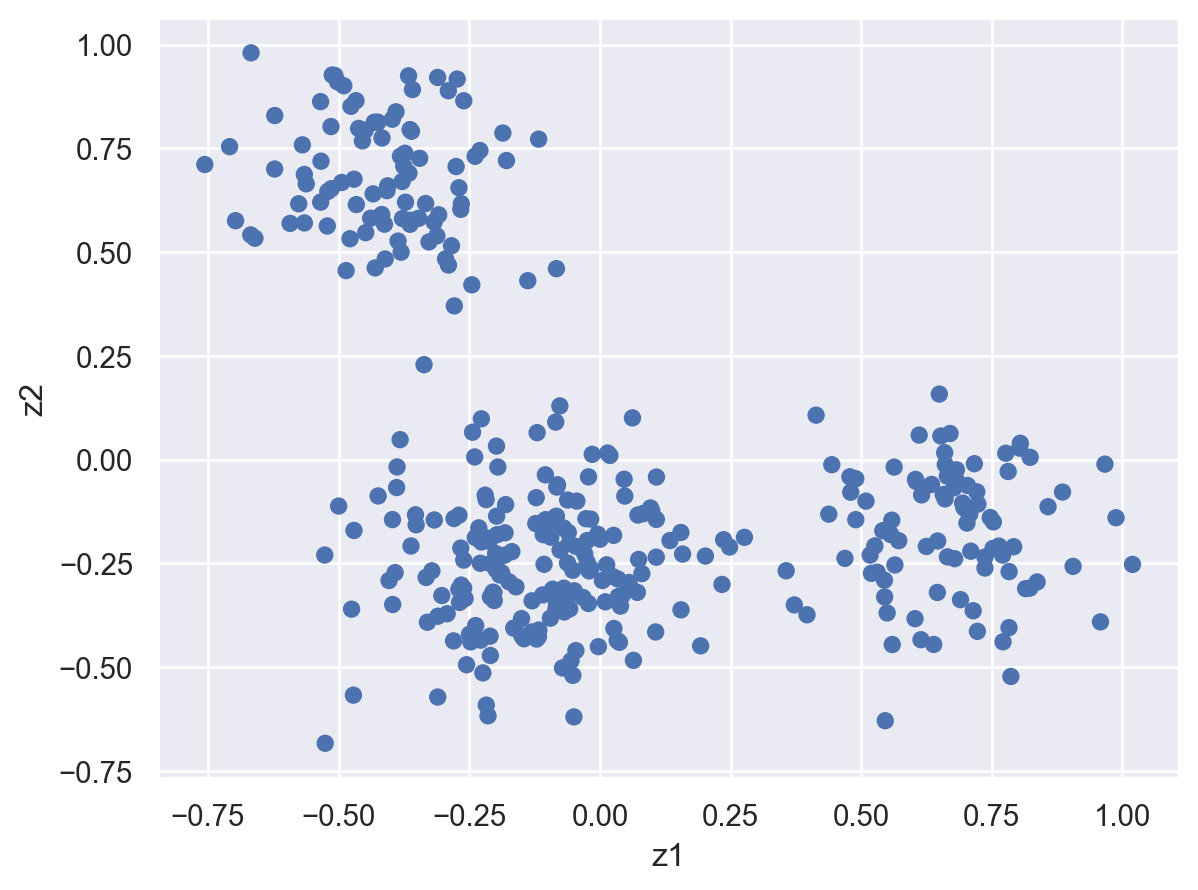

In [99]:
(
    so.Plot(data=df_rios, x="z1",y="z2")
    .add(so.Dot())
)

Podemos observar, de vuelta, 3 clusters.

### Inciso d

Utilizando el método de clustering que considere apropiado, clasificar a los datos en 4 clusters utilizando solo las variables $z_1$ y $z_2$ y realizar nuevamente el gráfico de dispersión de $z_1$ y $z_2$ coloreando cada punto según el cluster al que pertenece.

-------------------------------------------------------------

Elijo K-means porque tienen forma circular y bastante isótropica los clusters.

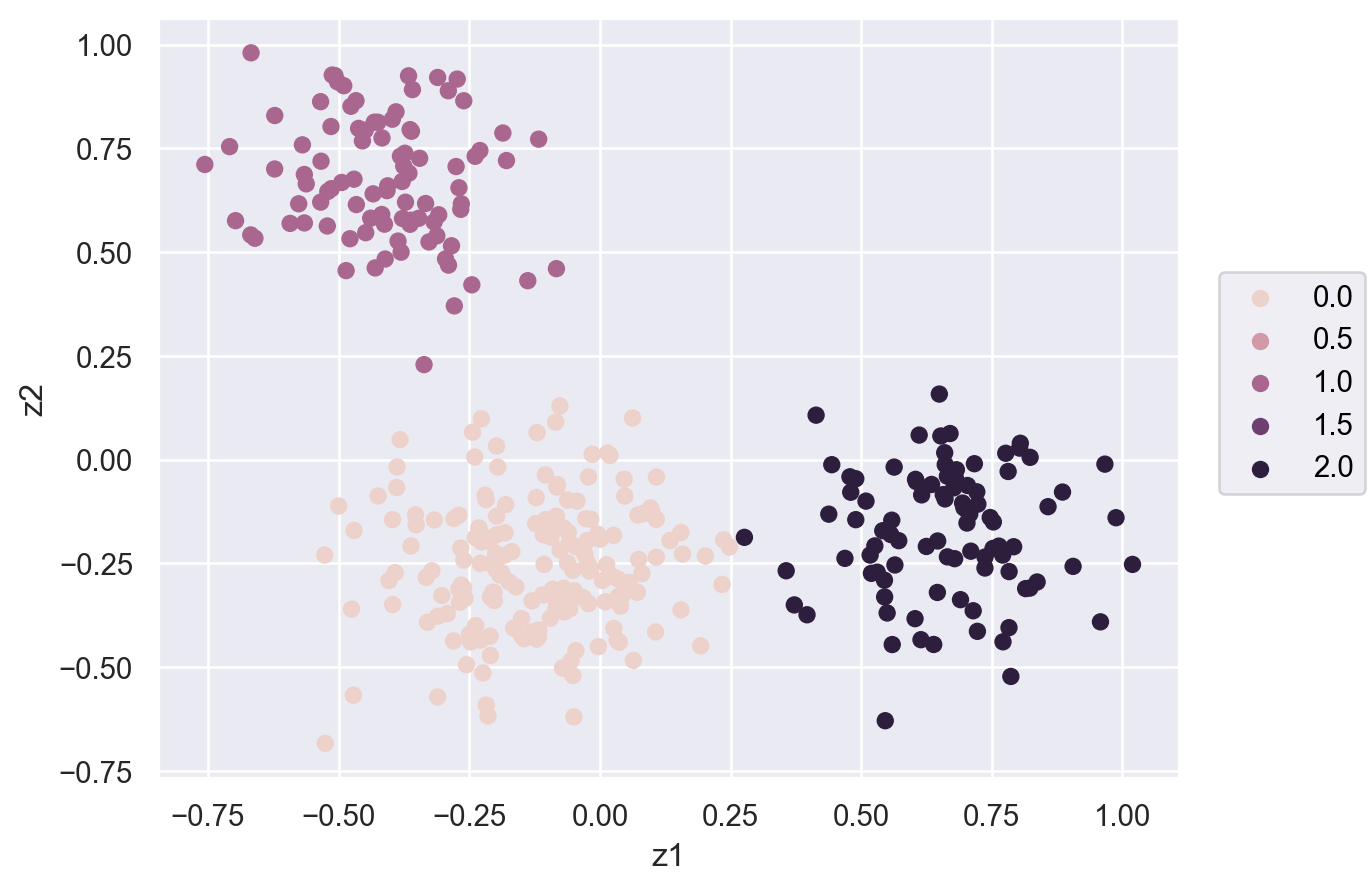

In [109]:
# Tomamos K-Means con 3 clusters
kmeans = KMeans(n_clusters=3)

# Asignamos a cada observación un cluster
etiquetas = kmeans.fit_predict(df_rios)

# Grafico los datos
(
    so.Plot(data= df_rios, x = "z1", y = "z2",color=etiquetas)
    .add(so.Dot())
)